### Function for detecting lake-breeze fronts
We will build a function that predicts whether a lake-breeze front (LBF) will pass one of O'Hare and Midway airports for a 24-h timeseries, and the time of day this occurs. As we are looking for abrupt changes in surface variables, we will want a derivative with respect to time. What variables?

* 10-m wind (speed and direction)
* 2-m dry-bulb, wet-bulb, dewpoint temperature (or other moisture)
* Incoming short-wave radiation, or solar flux
* Pressure
* Pollution? (PM2.5, $O_3$, etc)

You can use the interface with Synoptic (`import synoptic`, or the package `SynopticPy`) to see what other locations and variables there are available. Use their online documentation too. We will keep it simple right now and use only limited variables for this notebook example. We always must remember what the point is. We want to give an "answer" about wind shifts to the Random Forest, so it associates the other values that correspond to that time's sample. We also only want to detect lake-breeze-related frontal passages.

What is our order of logic?
1. Load observation data for a lake-breeze frontal passage at observation site(s)
2. Determine which variables seem most pertinent; visualise their time series and d/dt
3. Develop a threshold that triggers yes/no on LBF passage at the two locations
4. If "yes" is triggered, at what time is the front likely to pass?
5. How do we remove false positives of larger-scale fronts? What about "second waves" or land-breeze switches within the same day?

Once we have a function to detect the front, this can be applied to many days' worth of data to generate a "LBF passage" variable.

It might be that observations at one time alone will not be enough. Perhaps each day's training day are processed variables such as "change in pressure since 00Z" or "maximum temperature the previous day". So many choices! If we have time or the desire, we may look at using HRRR forecasts that let us predict for later in the day (the observed values for, e.g., 18Z U-wind can be substituted for forecast values with the assumption that will still give us a decent forecast).

In [77]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
import numpy as np
from synoptic.services import stations_timeseries, stations_nearesttime

In [78]:
def get_obs_data(**kw):
    df = stations_timeseries(**kw)
    drop_cols = [v for v in df.columns if not "_set_" not in v]
    df = df.drop(columns=drop_cols)
    df = df.dropna()
    return df

def snap_to_timegrid(df,mn):
    return df.resample('s').interpolate().resample(f'{mn:02d}T').asfreq()

In [79]:
kw = {
    "stid":"KORD",
    "vars":["air_temp","wind_direction","wind_speed","dew_point_temperature"],
    "start":datetime.datetime(2022,6,27,9,0,0),
    "end":datetime.datetime(2022,6,28,9,0,0),
}

df = get_obs_data(**kw)
df


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=KORD&vars=air_temp,wind_direction,wind_speed,dew_point_temperature&start=202206270900&end=202206280900&token=🙈HIDDEN



,air_temp,dew_point_temperature,wind_direction,wind_speed,wind_u,wind_v
date_time,,,,,,
2022-06-27 09:00:00+00:00,17.0,8.95,290.0,3.087,2.901,-1.056
2022-06-27 09:05:00+00:00,17.0,8.95,290.0,3.087,2.901,-1.056
2022-06-27 09:10:00+00:00,17.0,8.95,300.0,4.116,3.565,-2.058
2022-06-27 09:15:00+00:00,17.0,8.95,290.0,3.601,3.384,-1.232
2022-06-27 09:20:00+00:00,17.0,8.95,290.0,3.601,3.384,-1.232
...,...,...,...,...,...,...
2022-06-28 08:45:00+00:00,17.0,7.94,200.0,2.058,0.704,1.934
2022-06-28 08:50:00+00:00,17.0,7.94,190.0,3.087,0.536,3.040
2022-06-28 08:51:00+00:00,16.7,7.74,190.0,3.087,0.536,3.040


You'll see the data points are mostly every five minutes, but there are additional times. As we want to look at regular differences, let's get the data onto a regular grid (every five minutes). Note that other weather stations may not be the same data frequency.

In [80]:
def plot_meteogram(df,title):
    fig,ax1 = plt.subplots(1,figsize=(11,4))

    ax1.plot(df.index,df.wind_u,color="blue")
    ax1.axhline(y=0,)

    ax2 = ax1.twinx()
    ax2.plot(df.index,df.air_temp,color="red")
    ax2.set_ylabel("Dry-bulb/dewpoint temperature (degC)")
    ax2.plot(df.index,df.dew_point_temperature,color="green")

    ax1.xaxis.set_major_locator(HourLocator())
    ax1.xaxis.set_major_formatter(DateFormatter("%HZ"))
    ax1.set_xlim([df.index.min(),df.index.max()])

    ax1.set_title(title)
    return fig,ax1

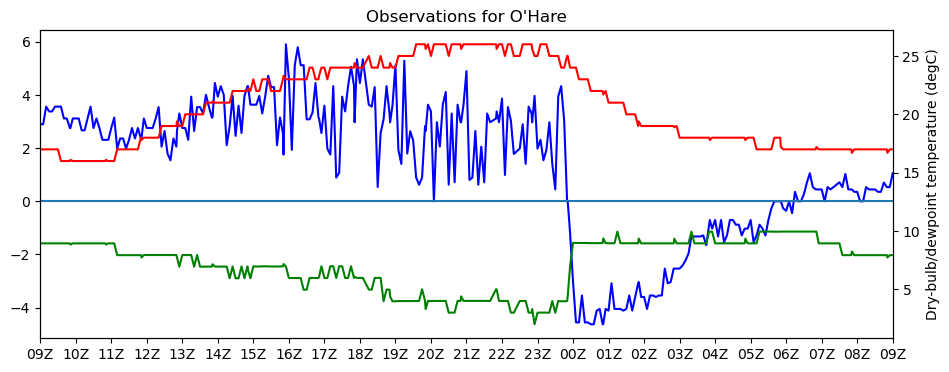

In [81]:
fig,ax = plot_meteogram(df,"Observations for O'Hare")

Let's think of three criteria, of which at least must be matched (at a minimum, you'd think!) to say "yes" to a LBF:

1. There is a *sudden* reversal in wind direction (or increasingly negative U component?)
2. There is a *sudden* drop in temperature
3. There is a *sudden* increase in dewpoint temperature

Some questions already come to mind.
* Would relative humidity (RH) be better as detection of a lake breeze frontal passage? Temperature should drop and dewpoint should rise: is this accentuated by RH?
* How do we define "sudden"? How do we set a threshold to exceed until a criterion is triggered?
* Do we use a relative threshold (e.g., temperature drops 0.1 times the day's "control" diurnal range)?
    - "Control" is somewhere further inland not affected by lake influence.
* Do we use an absolute threshold (e.g., the on-flow component of the wind must increase over time, even if the wind magnitude does not)?
* How many of our criteria must be triggered to activate a grand-total "yes"? How do we identify a time?

Put most abstractly, to detect a sudden change dx in variable x over a short time dt, du/dt is negative and is smaller than an unknown threshold when a LBF passes. Similarly (and assumingly with the same optimal dt), we expect dT/dt to be negative and dTd/dt to be positive.

We could consider different ways of computing gradients. You could look around the internet for hundreds of other researchers' methods. For instance, there's `numpy.diff` or `numpy.gradient`. There are in-built pandas tools like `pandas.diff`. You could even use `scikit-learn` to use machine learning to identify sudden changes in the time series! Here's an example below of using 15-minute windows of variable changes to highlight very plainly to the human eye where the lake breeze passed KORD, and which variables it was evident in. It's now up to you to (1) explore other variables (solar incoming; pressure; etc) or combinations/derivations thereof (RH, density, pressure change over time, etc); and (2) mimic how the human eye sees the changes to create a new column or variable of "lake breeze likely passing at this time".

In [82]:
# Get rid of obs not every five min (variable mn)
# Make sure this is valid for every obs station!
df = snap_to_timegrid(df,mn=5)

In [83]:
def do_diff_df(df,dt,mn):
    return df.diff(periods=int(dt/mn))

def plot_differences(df,xlims=None):
    fig,axes = plt.subplots(nrows=2,ncols=1,dpi=200,figsize=(11,4))

    axes[0].plot(df["wind_u"],color="blue",lw=0.4)
    axes[0].fill_between(df.index,0,df["wind_u"],facecolor="blue",alpha=0.15)
    axes[0].set_ylabel("U component of wind")

    axes[1].plot(df["air_temp"],color="red",lw=0.4)
    axes[1].fill_between(df.index,0,df["air_temp"],facecolor="red",alpha=0.15)

    axes[1].plot(df["dew_point_temperature"],color="green",lw=0.4)
    axes[1].fill_between(df.index,0,df["dew_point_temperature"],facecolor="green",alpha=0.15)

    axes[1].set_ylabel("Temperatures (C)")

    # If we want to make the y=0 line clear:
    # (We might instead want to use the day's median or mean changes to show the change)
    # axes[1].axhline(y=0,color="blue")
    # axes[1].axhline(y=0,color="black")

    for n in (0,1):
        axes[n].xaxis.set_major_locator(HourLocator())
        axes[n].xaxis.set_major_formatter(DateFormatter("%HZ"))
        if xlims is not None:
            axes[n].set_xlim(*xlims)

    return fig,ax


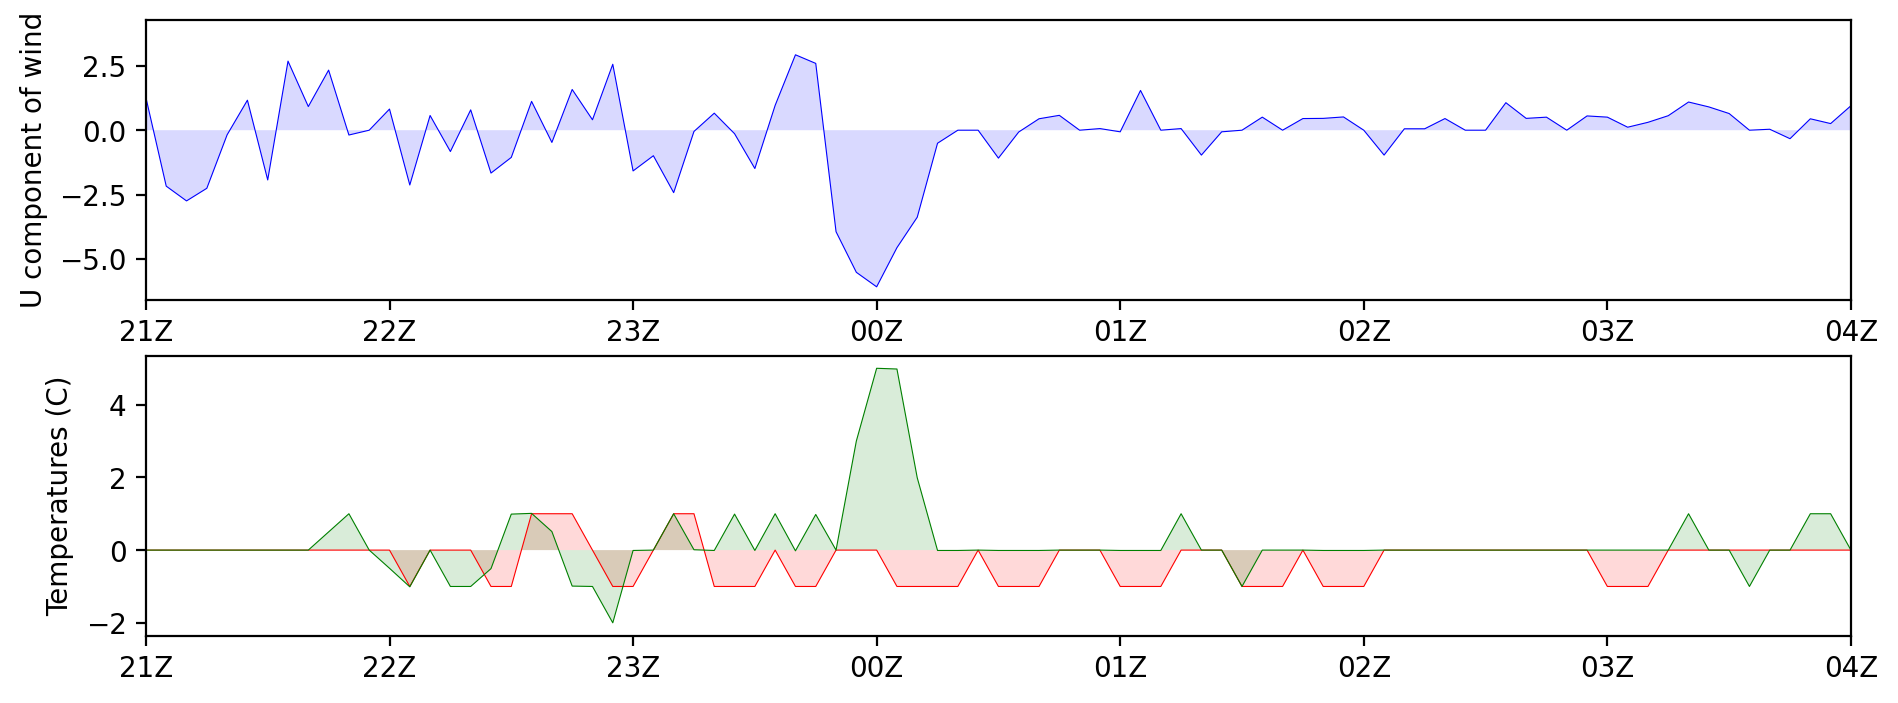

In [84]:
# Variable dt is the number of mins to work out dx/dt over
# Try changing this to see the effect on the figure below
diff_df = do_diff_df(df,dt=15,mn=5)
fig,ax = plot_differences(diff_df,xlims=[datetime.datetime(2022,6,27,21,0,0), datetime.datetime(2022,6,28,4,0,0)])

We want (1) the day to be marked with a "yes" for a lake-breeze passage and (2) the time to be marked with "most likely time".

For no. 1, we need a trigger like...

In [85]:
# To test this, let's import a whole summer at O'Hare and find a few days
# We'll manually determine a LBF to ensure our method works

# Avoid synoptic wind - one criteria must be average wind around sunrise to be below X m/s
# Avoid large-scale fronts - first criteria helps, but also only allow increase in u-direction
# Some maybe we want to form a dataset for 2022 Summer where each 09Z - 09Z day has

# We pick 0900Z to reduce influence of late-night undular bores, land breezes, etc
kw = {
    "stid":"KORD",
    "vars":["air_temp","wind_direction","wind_speed","dew_point_temperature"],
    "start":datetime.datetime(2022,6,1,9,0,0),
    "end":datetime.datetime(2022,10,1,9,0,0),
}

df2 = get_obs_data(**kw)
df2 = snap_to_timegrid(df2,mn=5)
df2


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=KORD&vars=air_temp,wind_direction,wind_speed,dew_point_temperature&start=202206010900&end=202210010900&token=🙈HIDDEN



,air_temp,dew_point_temperature,wind_direction,wind_speed,wind_u,wind_v
date_time,,,,,,
2022-06-01 09:00:00+00:00,21.0,18.99,0.0,0.000,0.000,0.000
2022-06-01 09:05:00+00:00,21.0,18.99,0.0,0.000,0.000,0.000
2022-06-01 09:10:00+00:00,21.0,20.00,210.0,1.543,0.772,1.336
2022-06-01 09:15:00+00:00,21.0,20.00,200.0,2.058,0.704,1.934
2022-06-01 09:20:00+00:00,21.0,20.00,190.0,2.058,0.357,2.027
...,...,...,...,...,...,...
2022-10-01 08:40:00+00:00,11.0,8.98,350.0,2.058,0.357,-2.027
2022-10-01 08:45:00+00:00,11.0,8.98,340.0,1.543,0.528,-1.450
2022-10-01 08:50:00+00:00,11.0,8.98,330.0,2.058,1.029,-1.782


In [86]:
# Let's run each day through our detection
dates = np.unique(df2.index.date)
print(f"There are {len(dates)} dates in the dataset.")

# Just to have a look at the first 06Z--06Z period
for date in dates[0:1]:
    start_dt = pd.Timestamp(ts_input=datetime.datetime(date.year,date.month,date.day,9,0,0),tz="UTC")
    # This date 6Z and the next 6Z
    end_dt = start_dt + pd.Timedelta(days=1)
    # Subset
    sub_df = df2[(start_dt < df2.index) & (df2.index < end_dt)]

sub_df

There are 123 dates in the dataset.


,air_temp,dew_point_temperature,wind_direction,wind_speed,wind_u,wind_v
date_time,,,,,,
2022-06-01 09:05:00+00:00,21.0,18.99,0.0,0.000,0.000,0.000
2022-06-01 09:10:00+00:00,21.0,20.00,210.0,1.543,0.772,1.336
2022-06-01 09:15:00+00:00,21.0,20.00,200.0,2.058,0.704,1.934
2022-06-01 09:20:00+00:00,21.0,20.00,190.0,2.058,0.357,2.027
2022-06-01 09:25:00+00:00,21.0,20.00,180.0,2.058,-0.000,2.058
...,...,...,...,...,...,...
2022-06-02 08:35:00+00:00,16.0,12.98,230.0,1.543,1.182,0.992
2022-06-02 08:40:00+00:00,16.0,12.98,230.0,1.543,1.182,0.992
2022-06-02 08:45:00+00:00,16.0,12.98,210.0,1.543,0.772,1.336


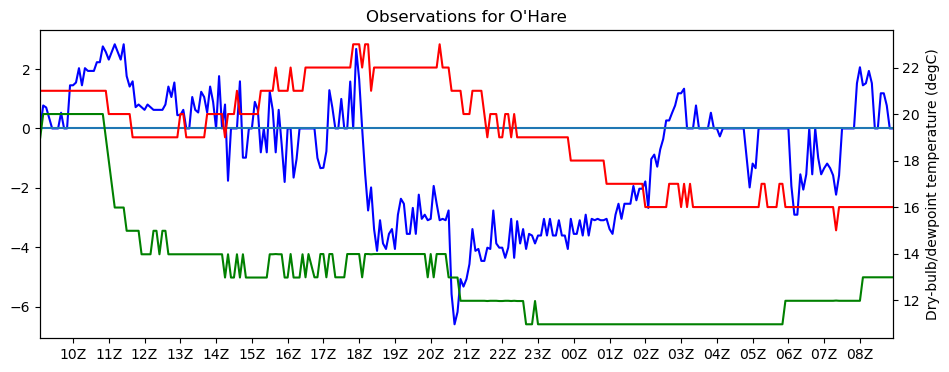

In [87]:
fig,ax = plot_meteogram(sub_df,"Observations for O'Hare")

We're going in blind here. Data at one site only, just for demonstration purpose, but you will need to contextualise yourself with more available data. Some initial thoughts on the above without knowing anything else:

* Looks like a big wind shift around 18Z with the lake-breeze tailing off towards 03Z?
* There isn't a temperature drop, but it reaches the daytime max at the wind-shift time
* Is there a better way of visualising/automating detection of daytime high being curtailed?
* How about a weather station further inland? The RF prediction would consider this growing PM temp difference
* What is the v-component? We need to rule out a raging southerly/northerly!
* There isn't a dewpoint change. Does that matter as much as wind?

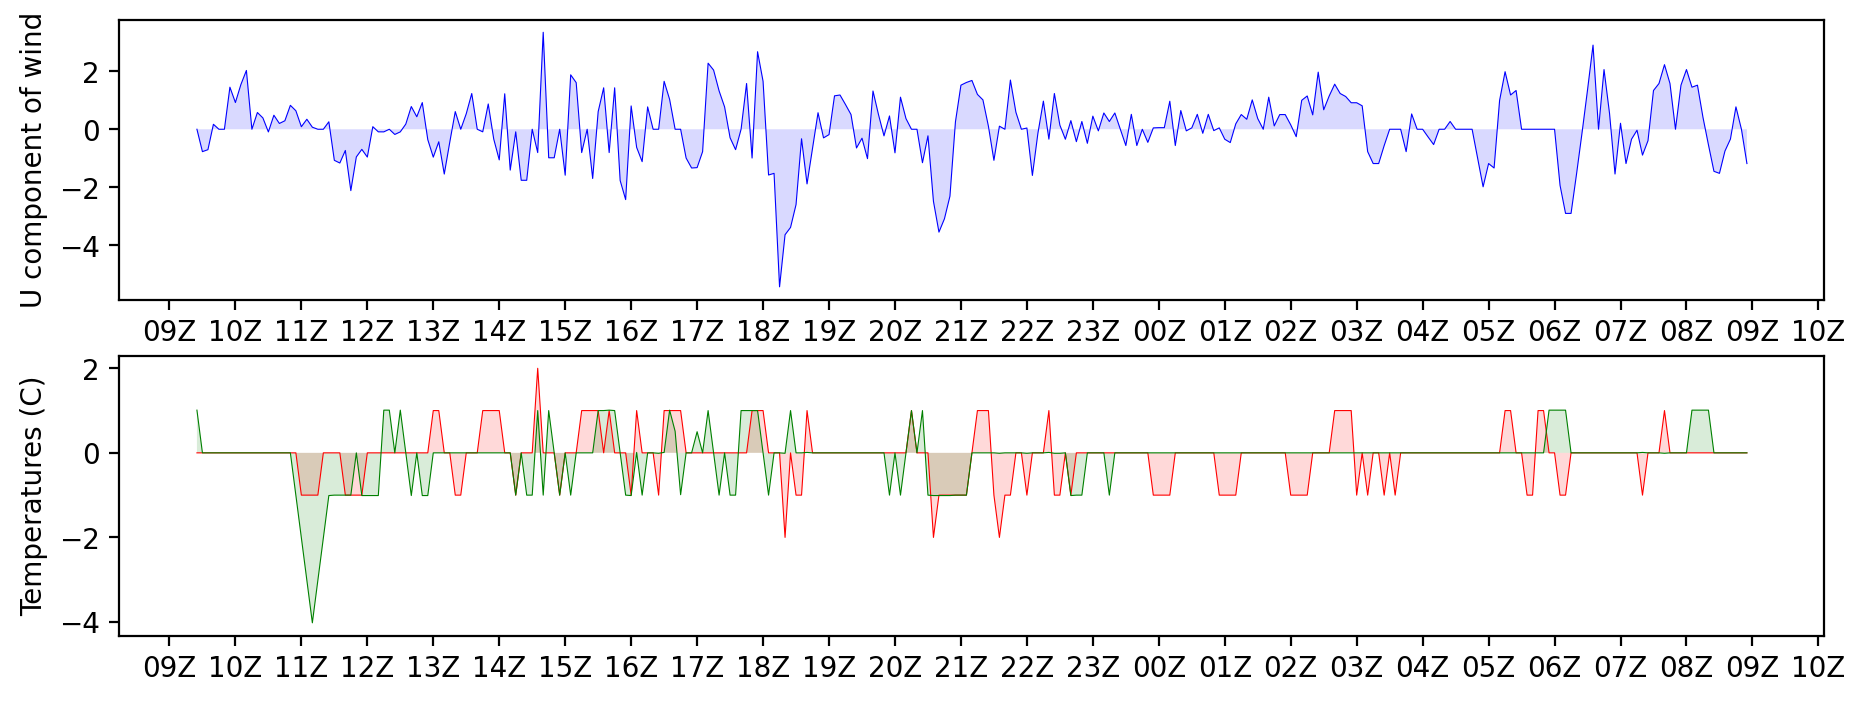

In [88]:
# Again, try changing dt to see if a different time window highlights changes better
diff_df = do_diff_df(sub_df,dt=20,mn=5)
fig,ax = plot_differences(diff_df)

Of course, you need to put context to this. You can use mesowest.utah.edu to more quickly see a geographical map of observations with time (archived with the same data you're using here), or look at archived analyses to see if e.g. large-scale flow supported lake breezes near Chicago on that day. Gather a few days that look like they likely had a breeze, and others that didn't. What discriminated between them in the station observations?

The aim now is to now write some logic that determines a positive or negative occurrence of LBF passage at a location. You can make it simple and only detect a sudden increase in easterlies at KORD and KMDY (du/dt < 0 with short enough dt), but you must decide on the threshold and so on. Try thinking in words first: "There needs to be a sudden increase in easterlies during the day. The time of passage will be the time of minimum du/dt. I can rule out days with a wind magnitude exceeding 10 m/s..." and so on.